
### 🦥 Unsloth is growing! Come join us :)
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a>

Up to $500K USD salary + bonus equity, health care benefits + other benefits, USA relocation etc! Complete some puzzles and earn points!

* We encourage you to use AI for coding!<ins> No experience or PhD / Masters needed</ins> - just get enough points for consideration!
* There are <ins>negative points</ins> for incorrect submissions. Read each criteria! Read [Submission](#SUBMISSION) steps.

| Role              | Compensation   | Role Description | Points Needed |
| ----------------- | -------------- | ----------- | --- |
| Founding Engineer | \$400K to \$500K & equity | Help push Unsloth forward - bug fixes, core features, UI, kernels, nearly anything! | 47 |
| ML Engineer | \$250K to \$300K & equity | Help with FSDP2, Float8, Float4, kernels, Unsloth core and more! | 32 |
| ML Intern | up to \$150K py | Implementing specific features in Unsloth core. Can be remote.  | 18 |

1. [Convert `nf4` to Triton](#NF4) [Difficulty: Hard] [Max points: 14]
2. [Make `QLoRA` work with `FSDP2`](#FSDP2) [Difficulty: Medium to Hard] [Max points: 12]
3. [Make `torch.compile` work without graph breaks for QLoRA](#COMPILE) [Difficulty: Easy to Medium] [Max points: 9]
4. [Help solve 🦥 Unsloth issues!](#ISSUES) [Difficulty: Varies] [Max points: 12]
5. [Memory Efficient Backprop](#MATH) [Difficulty: Medium to Hard] [Max points: 10]
6. [Submission steps](#SUBMISSION)

### 🦥 Who are we?
* 1.58bit DeepSeek R1 GGUFs [Tweet](https://x.com/UnslothAI/status/1883899061893546254) and [HF Model Page](https://huggingface.co/unsloth/DeepSeek-R1-GGUF)
* GRPO Llama 3.1 8B on a free Colab [Tweet](https://x.com/UnslothAI/status/1887562753126408210)
* Gemma bug fixes [Tweet](https://x.com/danielhanchen/status/1765446273661075609) and bug fixes for Llama 3, Phi 3, Qwen 2.5 [Details](https://unsloth.ai/blog/phi3) Llama-fying Phi-4 [Details](https://unsloth.ai/blog/phi4)
* Gradient accumulation bug fixes [Tweet](https://x.com/danielhanchen/status/1846235913443262891) 4bit Dynamic Quantization [Details](https://unsloth.ai/blog/dynamic-4bit)
* Unsloth Gradient Checkpointing async offloads activations [Details](https://unsloth.ai/blog/long-context)
* 30K Github Stars [Github](https://github.com/unslothai/unsloth) & 7 million monthly downloads on [Hugging Face](https://huggingface.co/unsloth)
* PyTorch conference [video](https://www.youtube.com/watch?v=PdtKkc5jB4g) AI Engineer World's Fair [video](https://www.youtube.com/watch?v=pRM_P6UfdIc) GPU / CUDA MODE [talk](https://www.youtube.com/watch?v=hfb_AIhDYnA)


### Clarifications:
1. We'll compensate you if we interview you but don't hire you
2. \$100-\$1000 bounties for Task 4
3. Submissions must be Apache-2 licensed
4. Task 4 involves solving Github issues for OSS Unsloth
5. No time limit: rolling basis
6. US based preferred

Hello! I attempted all the questions except the GitHub issues!

Comments:
Used trainer and hugging face code as a base, so it's compatible with huggingface code.
---

1) **Convert NF4 to Triton**:  
   - Changed `rtol=0.01`, `atol=0.01`, and applied these settings only for `torch.float16` in options for T4 GPU.  
   - Implemented two versions of the kernel:  
     - One with `absmax2` as blocks, which includes `tl.debug_barrier`. This version could not be compiled using `torch.compile`.  
     - Another with `absmax` as blocks, which does not include `tl.debug_barrier`. This version works with `torch.compile` but is slightly slower.  
   - Both versions are provided below.  

2) **Make QLoRA work with FSDP2**:  
   - Executed the code on Kaggle and displayed the implementation here.  

3) **Completed**.  

4) **GitHub issues skipped**.  

5) **Memory-Efficient Backpropagation**:  
   - Improved efficiency by integrating `torch.compile`.  
   - For **LLaMA-1B**, the training loss aligns with the same loss function used.  
   - **GRPO** also matches and functions correctly. In GRPO, I included the clipping step as part of the loss and only returned the loss. In a real implementation, we should also return KL divergence, completion length, rewards, and additional factors if needed.  

A lot of monkey patching, so 🚀🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 lol

---




In [1]:
# Code to install Unsloth, Triton, Torch etc
%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [1]:
# Helpful functions used through the entire notebook
import torch
import torch.nn as nn
from transformers import set_seed
import time
import inspect
import os
major_version, minor_version = torch.cuda.get_device_capability()
HAS_BFLOAT16 = (major_version >= 8)
from inspect import currentframe as _C, getframeinfo
_F = lambda c: getframeinfo(c).lineno # Gets line number
WARN = lambda x: print(f"\033[31m{x}\033[0m") # Red colored warnings

# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
def NAME(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    return names[0] if len(names) != 0 else ""

def assert_same(x, y, line, dtype):
    assert(x.dtype == dtype)
    try: torch.testing.assert_close(x, y, check_stride = True, rtol=0.01, atol=0.01)
    except Exception as error:
        raise RuntimeError(
            f"Failed allclose at line [{line}]: {NAME(x)}, {NAME(y)}\n{str(error)}"
        )

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

---
---
---
<a name="NF4"></a>
## A) Convert `nf4` to Triton. [Difficulty: Hard] [Max points: 14]

1. Goal: Convert a `nf4` quantized tensor into `fp16` or `bf16` into a *single* Triton kernel The double dequant of the `absmax` and weight forming must be done in 1 Triton kernel. Must work on Tesla T4.
2. Must be faster than Unsloth's `fast_dequantize` by 1.15x or more, and not use large intermediate memory buffers.
3. Must not use `torch.compile`, but can use `trace.enabled` to help on writing Triton kernels.
4. Good material: [Unsloth `fast_dequantize` function](https://github.com/unslothai/unsloth/blob/main/unsloth/kernels/utils.py#L128), also [bitsandbytes `dequantize_blockwise`](https://github.com/bitsandbytes-foundation/bitsandbytes/blob/86b6c37a8ad448230cedb60753f63150b603a112/bitsandbytes/functional.py#L958)
5. Use `test_dequantize_function` to test your implementation.
6. No CUDA allowed. Custom CUDA inside of the Triton is allowed.
7. Watch Tim's videos on Youtube: [8-bit Optimizers](https://www.youtube.com/watch?v=2ETNONas068)

In [2]:
from bitsandbytes.nn import Linear4bit
from transformers.activations import ACT2FN
from unsloth.kernels.utils import fast_dequantize
from peft.utils.integrations import dequantize_module_weight as peft_dequantize
def unsloth_dequantize(weight):
    return fast_dequantize(weight.weight, weight.weight.quant_state)

def bnb_Linear4bit(hd, m, dtype = torch.float16):
    return Linear4bit(
        hd, m, bias = None,
        compute_dtype       = dtype,
        compress_statistics = True,
        quant_type          = "nf4",
    )

# [NEW] as at 18th Feb 2025
def assert_correct_bnb(weight, dtype):
    assert(weight.weight.dtype == torch.uint8)
    assert(weight.weight.quant_state.dtype == dtype)
    assert(weight.weight.quant_state.absmax.dtype == torch.uint8)
    assert(weight.weight.quant_state.code.dtype == torch.float32)
    assert(weight.weight.quant_state.offset.dtype == torch.float32)
    assert(weight.weight.quant_state.blocksize == 64)
    assert(weight.weight.quant_state.state2.absmax.dtype == torch.float32)
    assert(weight.weight.quant_state.state2.code.dtype == torch.float32)
    assert(weight.weight.quant_state.state2.blocksize == 256)

class MLP(nn.Module):
    def __init__(self, hd = 4096, m = 14336, dtype = torch.float16):
        super().__init__()
        self.gate_proj = bnb_Linear4bit(hd, m, dtype = dtype).to("cuda")
        self.up_proj   = bnb_Linear4bit(hd, m, dtype = dtype).to("cuda")
        self.down_proj = bnb_Linear4bit(m, hd, dtype = dtype).to("cuda")
        # [NEW] as at 18th Feb 2025
        self.gate_proj.weight.quant_state.dtype = dtype
        self.up_proj  .weight.quant_state.dtype = dtype
        self.down_proj.weight.quant_state.dtype = dtype
        self.act_fn = ACT2FN["silu"]
    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

def mlp_forward(X, mlp, fx):
    up   = X @ fx(mlp.  up_proj).t()
    gate = X @ fx(mlp.gate_proj).t()
    h = mlp.act_fn(gate) * up
    down = h @ fx(mlp.down_proj).t()
    return down

def mlp_dequantize(X, mlp, fx):
    a = fx(mlp.  up_proj).t(); torch.cuda.synchronize()
    b = fx(mlp.gate_proj).t(); torch.cuda.synchronize()
    c = fx(mlp.down_proj).t(); torch.cuda.synchronize()
    return a, b, c

def test_dequantize(dequantize_fx):
    elapsed = 0
    options = [
        (2, 3333, 2048,  8192, 3407, torch.float16),
        (5,  777, 1024,  4096, 3409, torch.float16),
        (3, 2048, 4096, 14336, 3408, torch.float16),
    ]
    for (bsz, qlen, hd, m, seed, dt) in options:
        set_seed(seed)
        torch.set_default_dtype(torch.float32)
        mlp = MLP(hd = hd, m = m, dtype = dt)
        X = torch.randn((bsz, qlen, hd), device = "cuda", dtype = dt)
        torch.cuda.synchronize()

        # Warmup
        for _ in range(2):
            assert_same( mlp_forward(X, mlp, dequantize_fx), mlp(X), _F(_C()), dt)
            # [NEW] as at 18th Feb 2025
            assert_correct_bnb(mlp.  up_proj, dt)
            assert_correct_bnb(mlp.gate_proj, dt)
            assert_correct_bnb(mlp.down_proj, dt)
            a, b, c = mlp_dequantize(X, mlp, dequantize_fx)
            A, B, C = mlp_dequantize(X, mlp, unsloth_dequantize)
            assert_same(a, A, _F(_C()), dt)
            assert_same(b, B, _F(_C()), dt)
            assert_same(c, C, _F(_C()), dt)

        # Benchmarking
        torch.cuda.synchronize()
        start = time.time()
        for _ in range(1000): mlp_dequantize(X, mlp, dequantize_fx)
        elapsed += time.time() - start
    return elapsed

<ipython-input-2-65cf205adda9>:3: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth.kernels.utils import fast_dequantize


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Write your Triton kernel below, and test it:

In [3]:
from triton import jit
import triton
import triton.language as tl
import pdb

@triton.jit
def _your_dequantize_nf4_kernel(#pointers
                                absmax2_ptr, out2_ptr, absmax1_ptr, out1_ptr, weight_ptr, code2_ptr, code1_ptr, offset1,
                                #Dimensions
                                blocksize1, blocksize2, num_elems_1, num_elems_2, shift1, shift2,
                                #meta param
                                BLOCK_SIZE: tl.constexpr, BLOCK_SIZE_2:tl.constexpr
                                ):

    #init
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask_for_abs2 = offsets < num_elems_2
    indexs = offsets >> shift2

    #de_doublequant
    absmax2_max = tl.load(absmax2_ptr + indexs,  mask = mask_for_abs2, other = 128)
    absmax1_values = tl.load(absmax1_ptr + offsets, mask = mask_for_abs2, other = 128)
    x = tl.load(code2_ptr + tl.cast(absmax1_values, tl.int32), mask = mask_for_abs2, other = 128)
    val_offset = tl.fma(x, absmax2_max, tl.load(offset1))

    tl.store(out2_ptr + offsets, val_offset, mask = mask_for_abs2, eviction_policy='evict_last')
    tl.debug_barrier()


    new_offsets = pid * BLOCK_SIZE_2 + tl.arange(0, BLOCK_SIZE_2)

    #indexs = new_offsets >> shift1
    indexs = tl.inline_asm_elementwise(
        asm ="""
        shr.b32 $0, $4, $8;
        shr.b32 $1, $5, $9;
        shr.b32 $2, $6, $10;
        shr.b32 $3, $7, $11;
        """,
         constraints=(
            "=r,=r,=r,=r,"
            "r,r,r,r,r,r,r,r"),
        args=[new_offsets, shift1],
        dtype=(tl.int32),
        is_pure=True,
        pack=4,
    )

    mask_for_abs1 = new_offsets < num_elems_1
    gathered_max = tl.load(out2_ptr + indexs, mask = mask_for_abs1, other = 128)
    weights_values = tl.load(weight_ptr + new_offsets, mask = mask_for_abs1, other=128)

    #high_bits = weights_values >> 4
    high_bits,  lowtem = tl.inline_asm_elementwise(
        asm="""
        {
          // --- Unpack the 32-bit input into 4 bytes ---
          .reg .b8 a<4>;
          // The input packed value is in $0.
          mov.b32 {a0, a1, a2, a3}, $8;

          // --- Convert each 8-bit value to a 32-bit integer ---
          cvt.u32.u8 $4, a0;
          cvt.u32.u8 $5, a1;
          cvt.u32.u8 $6, a2;
          cvt.u32.u8 $7, a3;
        }
        // --- Compute high nibble for each (byte >> 4) ---
        shr.b32 $0, $4, 4;
        shr.b32 $1, $5, 4;
        shr.b32 $2, $6, 4;
        shr.b32 $3, $7, 4;

        // --- Compute low nibble for each (byte & 0x0F) ---
        and.b32 $4, $4, 0x0F;
        and.b32 $5, $5, 0x0F;
        and.b32 $6, $6, 0x0F;
        and.b32 $7, $7, 0x0F;

    """,
         constraints=(
            "=r,=r,=r,=r,=r,=r,=r,=r,"
            "r"),
        args=[weights_values],
        dtype=(tl.int32, tl.int32),
        is_pure=True,
        pack=4,
    )

    x = tl.load(code1_ptr + high_bits, mask = mask_for_abs1, other=4)
    hi_val = x * (gathered_max)

    x = tl.load(code1_ptr + lowtem, mask = mask_for_abs1, other=4)
    lo_val = x  * (gathered_max)

    #storing
    out_hi2 =  new_offsets  * 2
    out_lo2 =  new_offsets  * 2 + 1
    tl.store(out1_ptr + out_hi2, hi_val  , mask = mask_for_abs1 , eviction_policy='evict_last')
    tl.store(out1_ptr + out_lo2, lo_val  , mask = mask_for_abs1 , eviction_policy='evict_last')

#@torch.compile(fullgraph=True)
def _your_dequantize_nf4(weight, quant_state):
    absmax2 = quant_state.state2.absmax
    blocksize2 = quant_state.state2.blocksize
    absmax1 = quant_state.absmax
    out2 = torch.empty(absmax1.shape, dtype=quant_state.dtype, device=absmax1.device)
    offset1 = quant_state.offset
    out1 = torch.empty(quant_state.shape, dtype=quant_state.dtype, device=weight.device)
    blocksize1 = quant_state.blocksize//2
    num_elems_1 = out1.numel()
    num_elems_2 = out2.numel()
    code2 = quant_state.state2.code
    code1 = quant_state.code
    shift1 =  blocksize1.bit_length() - 1
    shift2 = blocksize2.bit_length() - 1

    grid = lambda meta: (triton.cdiv(num_elems_2, meta['BLOCK_SIZE']),)

    kernal = _your_dequantize_nf4_kernel[grid](
        #wanna_be_pointers
        absmax2 , out2 , absmax1 , out1 , weight,code2,code1, offset1,
        #Dimensions
        blocksize1,blocksize2,num_elems_1,num_elems_2,  shift1, shift2,
        #meta_param
        BLOCK_SIZE = 64, BLOCK_SIZE_2 = 64*32
    )

    return out1

def your_dequantize_nf4(weight):
    return _your_dequantize_nf4(weight.weight.data, weight.weight.quant_state)

In [45]:
#----------------other version ----------------------
# from triton import jit
# import triton
# import triton.language as tl
# import pdb

# @triton.jit
# def _your_dequantize_nf4_kernel(#pointers
#                                 absmax2_ptr, absmax1_ptr, out1_ptr, weight_ptr, code2_ptr, code1_ptr, offset1,
#                                 #Dimensions
#                                 num_elems_1, num_elems_2, shift1, shift2,
#                                 #meta param
#                                 BLOCK_SIZE: tl.constexpr,
#                                 ):

#     #pdb.set_trace()
#     pid = tl.program_id(axis=0)

#     #tl.static_print("pid", pid)

#     new_offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)

#     #tl.static_print("new_offsets", new_offsets)

#     mask_for_abs1 = new_offsets < num_elems_1

#     #tl.static_print("mask_for_abs1", mask_for_abs1)

#     g = new_offsets >> shift1

#     #tl.static_print("g", g)

#     mask_for_g = g < num_elems_2

#     #tl.static_print("mask_for_g", mask_for_g)

#     # Recompute the intermediate value on the fly:
#     absmax2_val = tl.load(absmax2_ptr + (g >> shift2), mask=mask_for_g, other=128)
#     #tl.static_print("absmax2_val", absmax2_val)

#     absmax1_val = tl.load(absmax1_ptr + g, mask=mask_for_g, other=128)
#     #tl.static_print("absmax1_val", absmax1_val)
#     x_val = tl.load(code2_ptr + tl.cast(absmax1_val, tl.int32), mask=mask_for_g, other=128)
#     #tl.static_print("x_val", x_val)
#     gathered_max = tl.fma(x_val, absmax2_val, tl.load(offset1).cast(tl.float32))

#     #tl.static_print("gathered_max", gathered_max)


#     # Now process weights based on the recomputed gathered_max
#     weights_vals = tl.load(weight_ptr + new_offsets, mask=mask_for_abs1, other=128)
#     #tl.static_print("weights_vals", weights_vals)
#     high_bits = weights_vals >> 4
#     #tl.static_print("high_bits", high_bits)

#     x_hi = tl.load(code1_ptr + high_bits, mask=mask_for_abs1, other=4)
#     #tl.static_print("x_hi", x_hi)
#     hi_val = x_hi * gathered_max
#     #tl.static_print("hi_val", hi_val)

#     low_part = weights_vals & 0x0F
#     #tl.static_print("low_part", low_part)
#     x_lo = tl.load(code1_ptr + low_part, mask=mask_for_abs1, other=4)
#     #tl.static_print("x_lo", x_lo)
#     lo_val = x_lo * gathered_max
#     #tl.static_print("lo_val", lo_val)

#     # Compute output indices and store results
#     out_hi2 = new_offsets * 2
#     out_lo2 = new_offsets*2 + 1
#     tl.store(out1_ptr + out_hi2, hi_val, mask=mask_for_abs1)
#     tl.store(out1_ptr + out_lo2, lo_val, mask=mask_for_abs1)


# def _your_dequantize_nf4(weight, quant_state):
#     absmax2 = quant_state.state2.absmax
#     blocksize2 = quant_state.state2.blocksize
#     absmax1 = quant_state.absmax
#     #out2 = torch.empty(absmax1.shape, dtype=quant_state.dtype, device=absmax1.device)
#     offset1 = quant_state.offset
#     out1 = torch.empty(quant_state.shape, dtype=quant_state.dtype, device=weight.device)
#     blocksize1 = quant_state.blocksize//2
#     num_elems_1 = out1.numel()
#     num_elems_2 = absmax1.numel()
#     code2 = quant_state.state2.code
#     code1 = quant_state.code


#     shift1 =  blocksize1.bit_length() - 1
#     shift2 = blocksize2.bit_length() - 1

#     grid = lambda meta: (triton.cdiv(weight.numel(), meta['BLOCK_SIZE']),)

#     _your_dequantize_nf4_kernel[grid](
#         #pointers
#         absmax2 , absmax1 , out1 , weight , code2 , code1 , offset1,
#         #Dimensions
#         num_elems_1, num_elems_2, shift1, shift2,
#         #meta param
#         BLOCK_SIZE = 2048,
#     )

#     return out1

# def your_dequantize_nf4(weight):
#     return _your_dequantize_nf4(weight.weight.data, weight.weight.quant_state)

In [5]:
## TEST IT BELOW:
test_dequantize(your_dequantize_nf4)

## CALCULATE SPEEDUP (hopefully 1.15x faster or more)
test_dequantize(unsloth_dequantize) / test_dequantize(your_dequantize_nf4)

1.1295745450117198

## Marking Criteria for A) Max points = 14
```python
if attemped_A:
    A_score = 0
    if single_triton_kernel: A_score += 3
    speedup = old_time / new_time
    if speedup <= 1.00: A_score -= 3
    if speedup >= 1.05: A_score += 1
    if speedup >= 1.10: A_score += 2
    if speedup >= 1.15: A_score += 2
    if kernel_works_in_torch_compile: A_score += 1
    else: A_score -= 1
    if custom_asm_works: A_score += 3
    if uses_cache_eviction: A_score += 1
    if tested_in_f16_and_bf16: A_score += 1
    else: A_score -= 1
    final_score += A_score
else:
    final_score += 0
```

---
---
---
<a name="FSDP2"></a>
## B) Make `QLoRA` work with `FSDP2` [Difficulty: Medium to Hard] [Max points: 10]

1. Goal: Write a single Python script to finetune Llama 3.1 8B on 2x or more GPUs with FSDP2.

2. You must showcase this working in a free **Kaggle notebook with 2 x Tesla T4 GPUs**.

3. Pipeline parallelism is also fine, but must utilize [`zero bubble scheduling`](https://pytorch.org/docs/stable/distributed.pipelining.html#torch.distributed.pipelining.schedules.ScheduleInterleavedZeroBubble) somehow.

4. Can use a pre-quantized 4bit BnB safetensor file from [Unsloth's HF page](https://huggingface.co/unsloth) or a full 16bit one, but must do QLoRA.

5. Can use `accelerate` but must be FSDP2 or related - you can investigate https://github.com/huggingface/accelerate/pull/3394, Torch Titan, other repos etc.

6. Must be fully `transformers` compatible - so we must use `TrainingArguments` and `Trainer`, or `TRL` related classes.

7. The loss must be equivalent to single GPU training.

8. You must enable all features in FSDP2 - ie showcase offloading, checkpointing, mixed precision training etc.

9. You can use `nf4` from `torch AO`, but best from `bitsandbytes`.

10. Finally showcase everything working in a free Kaggle 2x Tesla T4 notebook.

Ran on Kaggle :

In [6]:
# HELPFUL functions to undo Unsloth patches:
import sys

def remove_patched_module(package_name):
    modules_to_delete = [
        name for name in sys.modules
        if name == package_name or name.startswith(package_name + ".")
    ]
    for name in modules_to_delete: del sys.modules[name]

remove_patched_module("trl")
remove_patched_module("transformers")
remove_patched_module("peft")
remove_patched_module("bitsandbytes")

In [ ]:
def dequantize_bnb_weight_temp_patched(weight: "torch.nn.Parameter", dtype: "torch.dtype", state=None):
    """
    Helper function to dequantize 4bit or 8bit bnb weights.

    If the weight is not a bnb quantized weight, it will be returned as is.
    """
    if not isinstance(weight, torch.nn.Parameter):
        raise TypeError(f"Input weight should be of type nn.Parameter, got {type(weight)} instead")

    cls_name = weight.__class__.__name__
    if cls_name not in ("Params4bit", "Int8Params"):
        return weight

    if cls_name == "Params4bit":
        output_tensor = your_dequantize_nf4(weight.data, weight.quant_state)
        logger.warning_once(
            f"The model is going to be dequantized in {output_tensor.dtype} - if you want to upcast it to another dtype, make sure to pass the desired dtype when quantizing the model through `bnb_4bit_quant_type` argument of `BitsAndBytesConfig`"
        )
        return output_tensor.to(dtype)

    if state.SCB is None:
        state.SCB = weight.SCB

    if hasattr(bnb.functional, "int8_vectorwise_dequant"):
        # Use bitsandbytes API if available (requires v0.45.0+)
        dequantized = bnb.functional.int8_vectorwise_dequant(weight.data, state.SCB)
    else:
        # Multiply by (scale/127) to dequantize.
        dequantized = weight.data * state.SCB.view(-1, 1) * 7.874015718698502e-3

    return dequantized.to(dtype)

The script below runs fine in Kaggle 2x Telsa T4s(check Kaggle notebook attached):

In [ ]:

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
import transformers.integrations.bitsandbytes
transformers.integrations.bitsandbytes.dequantize_bnb_weight = dequantize_bnb_weight_temp_patched

import os
import torch
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,"\
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"
from peft import get_peft_model, LoraConfig, TaskType
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
import os
max_seq_length = 2048
torch.set_default_dtype(torch.float16)
model_name = "unsloth/meta-Llama-3.1-8B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit              = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type       = "nf4",
    bnb_4bit_compute_dtype    = dtype,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    quantization_config = bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r = 64,
    lora_alpha = 128,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0,
    bias = "none",
    task_type = TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name: param.requires_grad_(True)
        else: param.requires_grad_(False)
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files = {"train" : url}, split = "train[:10%]")

fsdp_config = {
  "compute_environment": "LOCAL_MACHINE",
  "debug": False,
  "distributed_type": "FSDP",
  "downcast_bf16": "no",
  "enable_cpu_affinity": False,
  "fsdp_config": {
    "fsdp_activation_checkpointing": True,
    "fsdp_auto_wrap_policy": "TRANSFORMER_BASED_WRAP",
    "fsdp_backward_prefetch": "BACKWARD_PRE",
    "fsdp_cpu_ram_efficient_loading": True,
    "fsdp_forward_prefetch": True,
    "fsdp_offload_params": True,
    "fsdp_sharding_strategy": "FULL_SHARD",
    "fsdp_state_dict_type": "SHARDED_STATE_DICT",
    "fsdp_sync_module_states": True,
    "fsdp_use_orig_params": True
  },
  "machine_rank": 0,
  "main_process_ip": "",
  "main_process_port": 8000,
  "main_training_function": "main",
  "mixed_precision": "fp16",
  "num_machines": 2,
  "num_processes": 2,
  "rdzv_backend": "static",
  "same_network": True,
  "tpu_env": [],
  "tpu_use_cluster": False,
  "tpu_use_sudo": False,
  "use_cpu": False
}

training_args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 1,
        max_steps = 10,
        logging_steps = 1,
        output_dir = "outputs",
        seed = 3407,
        max_seq_length = max_seq_length,
        fp16 = model.get_input_embeddings().weight.dtype == torch.float16,
        bf16 = model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to = "none", # For W&B
        dataset_num_proc = 4,

        fsdp_config=fsdp_config
    )

trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    processing_class = tokenizer,
    args =training_args,
)
trainer.train()


Reminder your code must have the same loss curve over 60 steps or so.

In [7]:
#del model
import gc
gc.collect()
torch.cuda.empty_cache()

## Marking Criteria for B) Max points = 10
```python
if attemped_B:
    B_score = 0
    if FSDP2_works_with_QLoRA:
        if torch_compile_works: B_score += 5
        else: B_score += 3
        if uses_part_A_and_single_kernel_and_faster: B_score += 3
        elif uses_torchAO:
            if torchAO_slower_than_BnB: B_score -= 3
    elif TP_or_PP_with_QLoRA:
        if zero_bubble: B_score += 3
        else: B_score += 2
    elif FSDP1_works_with_QLoRA:
        B_score += 1
    if kaggle_notebook_2_tesla_t4_example:
        B_score += 2
    else:
        B_score = 0
    final_score += B_score
else:
    final_score -= 2
```

---
---
---
<a name="COMPILE"></a>
## C) Make `torch.compile` work without graph breaks for QLoRA [Difficulty: Easy to Medium] [Max points: 9]

1. Goal: Write a single Python script like task B), except the goal is to `torch.compile` all modules if possible.

2. There must NOT be graph breaks, and excessive re-compilations should not be seen.

3. You should have say max 30 compilations. Over 60 is definitely wrong.

4. The loss must match with the non compiled module.

5. Utilize patching as much as possible.

6. Think about which areas might need disabling for compilation. Think about regional compilation. How do we compile sections efficiently?

7. Log memory / VRAM usage, and monitor speedups as well.

8. Must work for QLoRA.

We provided a script below, and showcased how to detect if graph breaks are seen. We also torch compiled the MLP for Llama:

In [8]:
from warnings import warn
from typing import Callable, Optional, Tuple
import bitsandbytes.functional as F
from functools import reduce  # Required in Python 3
import operator

def prod(iterable):
    return reduce(operator.mul, iterable, 1)

torch_compile_options = torch_compile_options = {
    "epilogue_fusion"   : True,
    "max_autotune"      : True,
    "shape_padding"     : True,
    "trace.enabled"     : True,
    "triton.cudagraphs" : False,
}
@torch.compile(fullgraph=False, dynamic=True, options = torch_compile_options)
class MatMul4Bit(torch.autograd.Function):
    # forward is the same, but we added the fallback for pre-turing GPUs
    # backward is mostly the same, but adds one extra clause (see "elif state.CxB is not None")

    @staticmethod
    def forward(ctx, A, B, out=None, bias=None, quant_state: Optional[F.QuantState] = None):
        # default of pytorch behavior if inputs are empty
        ctx.is_empty = False
        if prod(A.shape) == 0:
            ctx.is_empty = True
            ctx.A = A
            ctx.B = B
            ctx.bias = bias
            B_shape = quant_state.shape
            if A.shape[-1] == B_shape[0]:
                return torch.empty(A.shape[:-1] + B_shape[1:], dtype=A.dtype, device=A.device)
            else:
                return torch.empty(A.shape[:-1] + B_shape[:1], dtype=A.dtype, device=A.device)

        # 1. Dequantize
        # 2. MatmulnN
        output = torch.nn.functional.linear(A, F.dequantize_4bit(B, quant_state).to(A.dtype).t(), bias)

        # 3. Save state
        ctx.state = quant_state
        ctx.dtype_A, ctx.dtype_B, ctx.dtype_bias = A.dtype, B.dtype, None if bias is None else bias.dtype

        if any(ctx.needs_input_grad[:2]):
            ctx.tensors = (None, B)
        else:
            ctx.tensors = (None, None)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        if ctx.is_empty:
            bias_grad = None if ctx.bias is None else torch.zeros_like(ctx.bias)
            return torch.zeros_like(ctx.A), torch.zeros_like(ctx.B), None, bias_grad, None

        req_gradA, _, _, req_gradBias, _ = ctx.needs_input_grad
        _, B = ctx.tensors

        grad_A, grad_B, grad_bias = None, None, None

        if req_gradBias:
            # compute grad_bias first before changing grad_output dtype
            grad_bias = grad_output.sum(0, dtype=ctx.dtype_bias)

        # not supported by PyTorch. TODO: create work-around
        # if req_gradB: grad_B = torch.matmul(grad_output.t(), A)
        if req_gradA:
            grad_A = torch.matmul(grad_output, F.dequantize_4bit(B, ctx.state).to(grad_output.dtype).t())

        return grad_A, grad_B, None, grad_bias, None

import bitsandbytes as bnb
from bitsandbytes.nn import Linear4bit

bnb.MatMul4Bit = MatMul4Bit

import torch
from torch.nn.attention.flex_attention import (
    _DEFAULT_SPARSE_BLOCK_SIZE,
    create_block_mask,
    create_mask,
    flex_attention,
)
from transformers.models.llama.modeling_llama import repeat_kv

torch_compile_options = torch_compile_options = {
    "epilogue_fusion"   : True,
    "max_autotune"      : True,
    "shape_padding"     : True,
    "trace.enabled"     : True,
    "triton.cudagraphs" : False,
}

@torch.compile(fullgraph=False, dynamic=True, options = torch_compile_options)
def compiled_llama_mlp(self, x):
    down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
    return down_proj

@torch.compile(fullgraph=False, dynamic=True, options = torch_compile_options)
def flex_attention_forward(
    module: nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    **kwargs,
):
    key_states = repeat_kv(key, module.num_key_value_groups)
    value_states = repeat_kv(value, module.num_key_value_groups)

    # 1. Define score_mod (This replaces the explicit weight calculation)
    def score_mod(score, b, h, q_idx, kv_idx):
        return score * scaling

    # 2. Define mask_mod (This handles masking, including causal masking)
    def mask_mod(b, h, q_idx, kv_idx):
        if attention_mask is None:
            return True # No Masking
        causal_mask = attention_mask[b, h, q_idx, kv_idx] # Accessing the mask for the specific batch, head, query and key
        return causal_mask.bool() # Convert to boolean

    # 3. Call flex_attention
    attn_output = flex_attention(query, key_states, value_states, score_mod=score_mod, mask_mod=mask_mod)

    attn_output = attn_output.transpose(1, 2).contiguous()

    # 4. Apply Dropout (Explicitly)
    attn_output = F.dropout(attn_output, p=dropout, training=module.training)  # Apply dropout here

    return attn_output, None

# @torch.compile(fullgraph=False, dynamic=True, options = torch_compile_options)
# class LlamaRMSNorm(nn.Module):
#     def __init__(self, hidden_size, eps=1e-6):
#         """
#         LlamaRMSNorm is equivalent to T5LayerNorm
#         """
#         super().__init__()
#         self.weight = nn.Parameter(torch.ones(hidden_size))
#         self.variance_epsilon = eps

#     def forward(self, hidden_states):
#         input_dtype = hidden_states.dtype
#         hidden_states = hidden_states.to(torch.float32)
#         variance = hidden_states.pow(2).mean(-1, keepdim=True)
#         hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
#         return self.weight * hidden_states.to(input_dtype)

#     def extra_repr(self):
#         return f"{tuple(self.weight.shape)}, eps={self.variance_epsilon}"


# def fixed_cross_entropy(source, target, num_items_in_batch: int = None, ignore_index: int = -100, **kwargs):
#     reduction = "sum" if num_items_in_batch is not None else "mean"
#     loss = nn.functional.cross_entropy(source, target, ignore_index=ignore_index, reduction=reduction)
#     if reduction == "sum":
#         loss = loss / num_items_in_batch
#     return loss


# @torch.compile(fullgraph=False, dynamic=True, options = torch_compile_options)
# def ForCausalLMLoss(
#     logits, labels, vocab_size: int, num_items_in_batch: int = None, ignore_index: int = -100, **kwargs
# ):
#     # Upcast to float if we need to compute the loss to avoid potential precision issues
#     logits = logits.float()
#     labels = labels.to(logits.device)
#     # Shift so that tokens < n predict n
#     labels = nn.functional.pad(labels, (0, 1), value=ignore_index)
#     shift_labels = labels[..., 1:].contiguous()

#     # Flatten the tokens
#     logits = logits.view(-1, vocab_size)
#     shift_labels = shift_labels.view(-1)
#     # Enable model parallelism
#     shift_labels = shift_labels.to(logits.device)
#     loss = fixed_cross_entropy(logits, shift_labels, num_items_in_batch, ignore_index, **kwargs)
#     return loss


import transformers.models.llama.modeling_llama
#transformers.models.llama.modeling_llama.LlamaMLP.forward = compiled_llama_mlp
transformers.models.llama.modeling_llama.eager_attention_forward = flex_attention_forward
transformers.models.llama.modeling_llama.LlamaRMSNorm = torch.compile(transformers.models.llama.modeling_llama.LlamaRMSNorm, fullgraph=False, dynamic=True, options = torch_compile_options)
transformers.loss.loss_utils.ForCausalLMLoss = torch.compile(transformers.loss.loss_utils.ForCausalLMLoss, fullgraph=False, dynamic=True, options = torch_compile_options)

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = \
    "expandable_segments:True,"\
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"

max_seq_length = 1024
torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit              = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type       = "nf4",
    bnb_4bit_compute_dtype    = dtype,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    quantization_config = bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r = 32,
    lora_alpha = 64,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0,
    bias = "none",
    task_type = TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name: param.requires_grad_(True)
        else: param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files = {"train" : url}, split = "train[:10%]")

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

unified_chip2.jsonl:   0%|          | 0.00/95.6M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

We provide full logging for `torch.compile` like below:

In [10]:
# Must show all graph breaks are not seen with torch.compile
import os
os.environ["TORCHDYNAMO_VERBOSE"] = "1"
os.environ["TORCHINDUCTOR_FORCE_DISABLE_CACHES"] = "1"
os.environ["TORCHINDUCTOR_COMPILE_THREADS"] = "1"

import logging
torch._inductor.config.debug = True
torch._logging.set_logs(
    dynamo = logging.WARN,
    inductor = logging.WARN,
    graph_breaks = True,
    recompiles = True,
    recompiles_verbose = True,
    compiled_autograd_verbose = True,
    # aot_joint_graph = True, # Enable for more logs
    # aot_graphs = True,
)
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = False

When we execute the code below, we can see graph breaks - remove them.

In [11]:
trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    processing_class = tokenizer,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2,
        warmup_steps = 1,
        max_steps = 10,
        logging_steps = 1,
        output_dir = "outputs",
        seed = 3407,
        max_seq_length = max_seq_length,
        fp16 = model.get_input_embeddings().weight.dtype == torch.float16,
        bf16 = model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to = "none", # For W&B
        dataset_num_proc = 4,
    ),
)
trainer.train()

Converting train dataset to ChatML (num_proc=4):   0%|          | 0/21029 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=4):   0%|          | 0/21029 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=4):   0%|          | 0/21029 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=4):   0%|          | 0/21029 [00:00<?, ? examples/s]

W0310 01:33:43.652000 6856 torch/_inductor/debug.py:434] [0/0] model__0_forward_1 debug trace: /content/torch_compile_debug/run_2025_03_10_01_33_39_677082-pid_6856/torchinductor/model__0_forward_1.0
W0310 01:33:45.528000 6856 torch/_inductor/debug.py:434] [0/0] model__0_backward_2 debug trace: /content/torch_compile_debug/run_2025_03_10_01_33_39_677082-pid_6856/torchinductor/model__0_backward_2.1


Step,Training Loss
1,1.519300
2,2.393000
3,2.499000
4,3.531300
5,2.135300
6,2.973600
7,2.242700
8,1.621300
9,2.216400
10,2.676600


TrainOutput(global_step=10, training_loss=2.3808391451835633, metrics={'train_runtime': 14.8098, 'train_samples_per_second': 1.35, 'train_steps_per_second': 0.675, 'total_flos': 10592155496448.0, 'train_loss': 2.3808391451835633})

In [12]:
del model
import gc
gc.collect()
torch.cuda.empty_cache()

Log all your steps for debugging in a Colab (maybe this one). Edward's blog http://blog.ezyang.com/, Horace's blogs https://www.thonking.ai/, Slaying OOMs by Jane & Mark: ttps://www.youtube.com/watch?v=UvRl4ansfCg could be useful.

## Marking Criteria for C) Max points = 9
```python
if attemped_C:
    C_score = 0
    if uses_flex_attention:
        if dynamic_sequence_length_works: C_score += 3
        else: C_score += 1
    if no_torch_compile_BnB: C_score -= 2
    elif use_part_A: C_score += 1
    elif torch_compile_BnB: C_score += 1

    if attention_compiled:
        if excessive_recompilation: C_score -= 3
        else: C_score += 2
    if mlp_compiled:
        if excessive_recompilation: C_score -= 3
        C_score += 1

    if not loss_compiled: C_score -= 1
    if not layernorms_compiled: C_score -= 3

    if max_autotune_triton_matmul:
        if excessive_recompilation: C_score -= 2
        else: C_score += 2
    
    final_score += C_score
else:
    final_score -= 1
```

---
---
---
<a name="ISSUES"></a>
## D) Help solve 🦥 Unsloth issues! [Difficulty: Varies] [Max points: 12]

Head over to https://github.com/unslothai/unsloth, and find some issues which are still left standing / not resolved. The tag **currently fixing** might be useful.

Each successfully accepted and solved issue will also have \$100 to \$1000 of bounties.

It's best to attempt these features:

* **<ins>Tool Calling</ins>** [Points = 1] Provide a tool calling Colab notebook and make it work inside of Unsloth. <ins>Bounty: \$1000</ins>

* **<ins>GGUF Vision support</ins>** [Points = 1] Allow exporting vision finetunes to GGUF directly. Llava and Qwen VL must work. <ins>Bounty: \$500</ins>

* **<ins>Refactor Attention</ins>** [Points = 2] Refactor and merge xformers, SDPA, flash-attn, flex-attention into a simpler interface. Must work seamlessly inside of Unsloth. <ins>Bounty: \$350</ins>

* **[DONE] <ins><del>Windows support</del></ins>** [Points = 2] Allow `pip install unsloth` to work in Windows - Triton, Xformers, bitsandbytes should all function. You might need to edit `pyproject.toml`. Confirm it works. <ins>Bounty: \$300</ins>

* **<ins>Support Sequence Classification</ins>** [Points = 1] Create patching functions to patch over AutoModelForSequenceClassification, and allow finetuner to use AutoModelForSequenceClassification. <ins>Bounty: \$200</ins>

* **<ins>VLMs Data Collator</ins>** [Points = 1] Make text & image mixing work efficiently -so some inputs can be text only. Must work on Qwen, Llama, Pixtral. <ins>Bounty: \$100</ins>

* **<ins>VLMs image resizing</ins>** [Points = 1] Allow finetuner to specify maximum image size, or get it from the config.json file. Resize all images to specific size to reduce VRAM. <ins>Bounty: \$100</ins>

* **<ins>Support Flex Attention</ins>** [Points = 2] Allow dynamic sequence lengths without excessive recompilation. Make this work on SWAs and normal causal masks. Also packed sequence masks. <ins>Bounty: \$100</ins>

* **<ins>VLMs train only on completions</ins>** [Points = 1] Edit `train_on_responses_only` to allow it to work on VLMs. <ins>Bounty: \$100</ins>


## Marking Criteria for D) Max points = 12
```python
if attemped_D:
    D_score = 0
    for subtask in subtasks:
        if sucessfully_completed_subtask:
            D_score += score_for_subtask
    final_score += D_score
```

---
---
---
<a name="MATH"></a>
## E) Memory Efficient Backprop [Difficulty: Medium to Hard] [Max points: 10]

In LLMs, the last layer is a projection matrix to calculate the probabilities of the next token, ie $\sigma(XW)$. However, if the vocabulary size is very large, say 128K, then the materialization of the logits causes VRAM spikes.

For example, if the `bsz = 4, qlen = 4096, hd = 4096, vocab = 128K`, then the memory usage for the logits in bfloat16 would be 4GB. In the worst case, we might even need to upcast logits to float32, so 8GB is needed.

In Unsloth, we utilize [Apple's Cut Cross Entropy Loss](https://machinelearning.apple.com/research/cut-your-losses) to reduce VRAM usage, by allowing a Triton kernel to create the logits on the fly to calculate the cross entropy loss. But this does not generalize well to other functions.

Our goal is to generalize this ultimately, but directly creating logits on the fly will be hard. Instead, let's take a slightly less complex approach. Let's first review some stuff. We first notice that during the normal case after forming the intermediate logits for 2 batches, we then do a gather function to aggregate the intermediate results into a single column:
$$
\begin{align}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \times W &= \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \\
f \bigg( \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \bigg) &= \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}
\end{align}
$$

So, if we can somehow skip the materialization of the intermediate logits, and just output the output of `f`, we can save a lot of VRAM!

Notice during backpropagation we can use the chain rule:
$$
\begin{align}
\frac{dL}{dX} &= \frac{dL}{dy} \frac{dy}{dX} ; \frac{dL}{dW} = \frac{dL}{dy} \frac{dy}{dW} \\
\frac{dL}{dy} &= \text{Downstream from backprop} \\
\frac{dy}{dX} &= W^T \\
\frac{dy}{dW} &= X^T \\
\frac{dL}{dX} &= \frac{dL}{dy} W^T \\
\frac{dL}{dW} &= X^T \frac{dL}{dy} \\
\end{align}
$$

If we simply compute the intermediate tensors on the fly via batches, say we do batch 1, then batch 2, we can reduce VRAM usage from 4GB to 2GB!

$$
\begin{align}
\frac{dL}{dX} &= \begin{bmatrix} \frac{dL_1}{dy_1} W^T \\ \frac{dL_2}{dy_2} W^T \end{bmatrix} \\
\frac{dL}{dW} &= \bigg( X_1^T \frac{dL_1}{dy_1} + X_2^T  \frac{dL_2}{dy_2} \bigg)
\end{align}
$$

1. Your goal is to write a `torch.autograd.Function` with a `forward` and `backward` pass showcasing this memory efficient implementation.

2. You must NOT hard code the derivatives - move the transformation function from the logits / intermeditate tensors to a smaller tensor as a separate function which can allow `autograd` to pass through it.

3. As a hint, look at `torch.checkpoint` at https://github.com/pytorch/pytorch/blob/main/torch/utils/checkpoint.py. Also, don't forget about the upstream gradients! We need to multiply them to the current gradients!

4. Make the Cross Entropy Loss work. You must show other functions working as well.

--- Testing Cross Entropy Transformation Function ---
Memory-Efficient | Chunk size:    1 | Loss:  11.9514 | Peak VRAM: 2373.12 MB | Final VRAM: 2373.12 MB
  Extra Stats: Allocated Peak: 2373.12 MB, Reserved Peak: 2612.00 MB, Active Peak: 2373.12 MB
Memory-Efficient | Chunk size:    2 | Loss:  11.9572 | Peak VRAM: 2373.12 MB | Final VRAM: 2373.12 MB
  Extra Stats: Allocated Peak: 2373.12 MB, Reserved Peak: 2612.00 MB, Active Peak: 2373.12 MB
Memory-Efficient | Chunk size:    4 | Loss:  11.9495 | Peak VRAM: 2373.12 MB | Final VRAM: 2373.12 MB
  Extra Stats: Allocated Peak: 2373.12 MB, Reserved Peak: 2612.00 MB, Active Peak: 2373.12 MB
Memory-Efficient | Chunk size:    8 | Loss:  11.9614 | Peak VRAM: 2373.12 MB | Final VRAM: 2373.12 MB
  Extra Stats: Allocated Peak: 2373.12 MB, Reserved Peak: 2612.00 MB, Active Peak: 2373.12 MB
Memory-Efficient | Chunk size:   16 | Loss:  11.9503 | Peak VRAM: 2373.12 MB | Final VRAM: 2373.12 MB
  Extra Stats: Allocated Peak: 2373.12 MB, Reserved Peak: 26

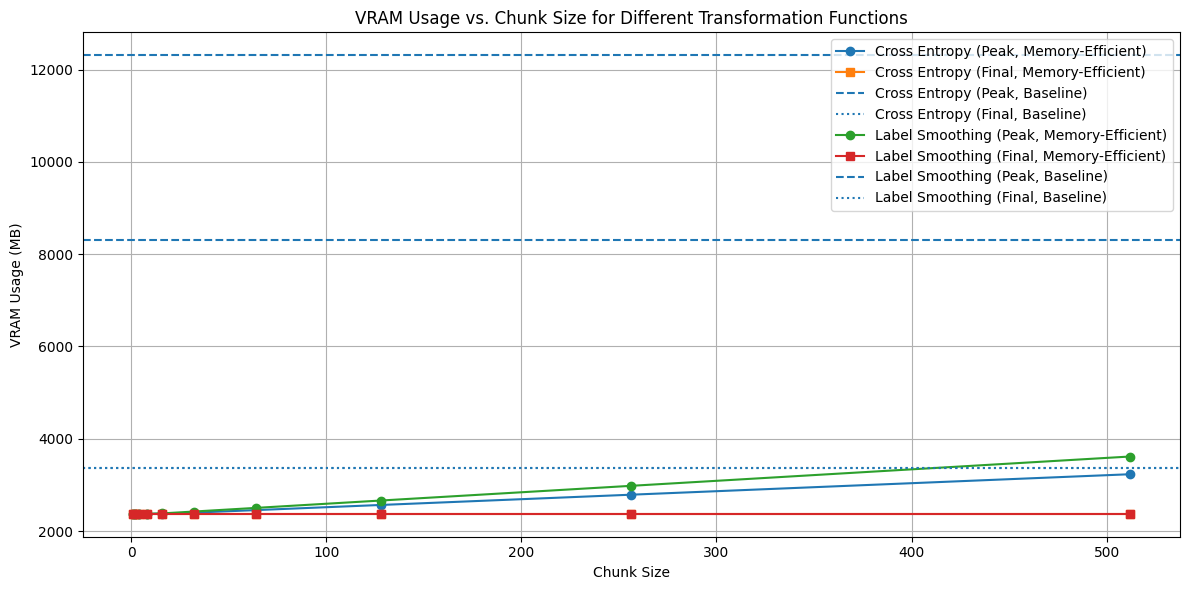

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class MemoryEfficientLinear(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, linear, labels, forward_function, chunk_size=None):

        bsz, seq_len, hd = X.shape
        # Flatten the batch and sequence dims.
        X_flat = X.reshape(-1, hd)         # shape: (bsz * seq_len, hd)
        labels_flat = labels.reshape(-1)     # shape: (bsz * seq_len,)
        total_tokens = X_flat.shape[0]

        if chunk_size is None:
            chunk_size = total_tokens // 2 if total_tokens > 1 else 1
        ctx.chunk_size = chunk_size

        # Determine valid tokens (assume -100 indicates positions to ignore).
        valid_mask = (labels_flat != -100)
        total_valid_tokens = valid_mask.sum().to(dtype=X.dtype)
        ctx.total_valid_tokens = total_valid_tokens

        total_loss = 0.0
        grad_chunks = []

        # Split the flattened inputs into chunks.
        X_chunks = torch.split(X_flat, chunk_size, dim=0)
        label_chunks = torch.split(labels_flat, chunk_size, dim=0)

        for chunk, lab in zip(X_chunks, label_chunks):
            # Count valid tokens in this chunk.
            valid_tokens_chunk = (lab != -100).sum().to(dtype=X.dtype)
            # Calculate the scaling factor for this chunk.
            scaling_factor = valid_tokens_chunk / total_valid_tokens if total_valid_tokens > 0 else 0.0

            # Here we define a lambda that wraps the transformation_function.
            compute_chunk_loss = lambda chunk_in: forward_function(chunk_in, linear, lab) * scaling_factor

            # Compute both the loss value and gradient for the chunk.
            chunk_grad, chunk_loss = torch.func.grad_and_value(
                compute_chunk_loss, argnums=0, has_aux=False
            )(chunk)
            total_loss += chunk_loss
            grad_chunks.append(chunk_grad)

        # Save the precomputed gradients to be used in backward.
        precomputed_grad = torch.cat(grad_chunks, dim=0)
        ctx.precomputed_grad = precomputed_grad
        ctx.input_shape = X.shape  # to reshape the gradient back to original dimensions
        return total_loss

    @staticmethod
    def backward(ctx, dY):
        # Retrieve the precomputed gradient and multiply by the upstream gradient.
        precomputed_grad = ctx.precomputed_grad
        grad_X_flat = precomputed_grad * dY
        grad_X = grad_X_flat.view(ctx.input_shape)

        return grad_X, None, None, None, None


# (1) Original Transformation Function using CrossEntropyLoss.
def transformation_function(flat_batch, linear, flat_labels):
    """
    Computes standard cross-entropy loss.

    Parameters:
      flat_batch: Tensor of shape (N, hd)
      linear: Linear layer mapping from hd to vocab
      flat_labels: Tensor of shape (N,), containing target class indices.

    Returns:
      loss: Scalar tensor representing the cross-entropy loss.
    """
    x = linear(flat_batch).float()  # shape: (N, vocab)


    ce_loss = nn.CrossEntropyLoss(ignore_index=-100, reduction="mean")
    loss = ce_loss(x, flat_labels)
    return loss

# (2) Label-Smoothing Transformation Function.
def label_smoothing_transformation_function(flat_batch, linear, flat_labels, smoothing=0.1):
    """
    Computes a label-smoothed cross-entropy loss.

    Parameters:
      flat_batch: Tensor of shape (N, hd)
      linear: Linear layer mapping from hd to vocab
      flat_labels: Tensor of shape (N,), containing target class indices.
      smoothing: The label smoothing factor (default is 0.1)

    Returns:
      loss: Scalar tensor representing the label-smoothed loss.
    """
    x = linear(flat_batch).float()  # shape: (N, vocab)
    log_probs = F.log_softmax(x, dim=1)

    num_classes = x.shape[1]
    with torch.no_grad():
        true_dist = torch.full_like(x, smoothing / (num_classes - 1))
        true_dist.scatter_(1, flat_labels.unsqueeze(1), 1.0 - smoothing)

    loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))
    return loss

# --- Experiment Settings ---
def run_experiment(chunk_size, transformation_fn, memory_efficient=True, device="cuda"):
    # Use smaller dimensions for testing purposes.
    bsz = 4
    qlen = 1000   # sequence length
    hd = 4096     # hidden dimension
    vocab = 128*1024  # vocabulary size
    total_tokens = bsz * qlen

    # Reset and record initial GPU memory stats if using CUDA.
    if device.type == "cuda":
        torch.cuda.empty_cache()  # Clear cache before measurement.
        initial_memory = torch.cuda.memory_allocated(device)
        torch.cuda.reset_peak_memory_stats(device)

    # Create new input tensor and corresponding labels.
    X = torch.randn(bsz, qlen, hd, device=device, requires_grad=True)
    labels = torch.randint(0, vocab, (bsz, qlen), device=device)

    # Create a linear layer.
    linear = nn.Linear(hd, vocab, bias=False).to(device)

    # Run forward/backward pass.
    if memory_efficient:
        loss = MemoryEfficientLinear.apply(X, linear, labels, transformation_fn, chunk_size)
    else:
        loss = transformation_fn(X.view(-1, hd), linear, labels.view(-1))
    loss.backward()

    if device.type == "cuda":
        # Peak and final VRAM usage in MB.
        peak_memory = torch.cuda.max_memory_allocated(device) / (1024**2)
        final_memory = torch.cuda.memory_allocated(device) / (1024**2)
        # Retrieve additional memory statistics.
        stats = torch.cuda.memory_stats(device)
        mem_stats = {
            "allocated_peak": stats["allocated_bytes.all.peak"] / (1024**2),
            "reserved_peak": stats["reserved_bytes.all.peak"] / (1024**2),
            "active_peak": stats["active_bytes.all.peak"] / (1024**2),
            "allocated_current": stats["allocated_bytes.all.current"] / (1024**2),
            "reserved_current": stats["reserved_bytes.all.current"] / (1024**2),
            "active_current": stats["active_bytes.all.current"] / (1024**2),
        }
    else:
        peak_memory = None
        final_memory = None
        mem_stats = None
    return loss.item(), peak_memory, final_memory, mem_stats, total_tokens

if __name__ == "__main__":
    # Determine device.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type != "cuda":
        print("CUDA is not available; VRAM measurement requires a GPU. Running on CPU without VRAM stats.")

    # Dictionary mapping function names to transformation functions.
    transformation_functions = {
        "Cross Entropy": transformation_function,
        "Label Smoothing": label_smoothing_transformation_function
    }

    # Run experiments for each transformation function.
    results = {}
    chunk_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
    for name, func in transformation_functions.items():
        print(f"--- Testing {name} Transformation Function ---")
        mem_usage = []
        final_mem_usage = []
        loss_vals = []
        extra_stats = []
        effective_cs = []
        for cs in chunk_sizes:
            loss_val, peak, final_mem, stats, total_tokens = run_experiment(cs, func, memory_efficient=True, device=device)
            eff_cs = cs if cs is not None else total_tokens // 2
            effective_cs.append(eff_cs)
            loss_vals.append(loss_val)
            if peak is not None:
                mem_usage.append(peak)
                final_mem_usage.append(final_mem)
                extra_stats.append(stats)
                print(f"Memory-Efficient | Chunk size: {eff_cs:>4} | Loss: {loss_val:>8.4f} | Peak VRAM: {peak:6.2f} MB | Final VRAM: {final_mem:6.2f} MB")
                print(f"  Extra Stats: Allocated Peak: {stats['allocated_peak']:.2f} MB, Reserved Peak: {stats['reserved_peak']:.2f} MB, Active Peak: {stats['active_peak']:.2f} MB")
            else:
                print(f"Memory-Efficient | Chunk size: {eff_cs:>4} | Loss: {loss_val:>8.4f}")
        results[name] = (effective_cs, mem_usage, final_mem_usage)

        # Run the baseline (full, non-chunked) experiment.
        base_loss, base_peak, base_final, base_stats, _ = run_experiment(chunk_size=None, transformation_fn=func, memory_efficient=False, device=device)
        if base_peak is not None:
            print(f"Baseline (full)           | Loss: {base_loss:>8.4f} | Peak VRAM: {base_peak:6.2f} MB | Final VRAM: {base_final:6.2f} MB")
            print(f"  Extra Stats: Allocated Peak: {base_stats['allocated_peak']:.2f} MB, Reserved Peak: {base_stats['reserved_peak']:.2f} MB, Active Peak: {base_stats['active_peak']:.2f} MB")
        else:
            print(f"Baseline (full)           | Loss: {base_loss:>8.4f}")
        results[name + "_baseline"] = (base_peak, base_final)
        print("\n")

    # Plot the VRAM usage vs. chunk size for each transformation function (if running on CUDA).
    if device.type == "cuda":
        plt.figure(figsize=(12, 6))
        for name in transformation_functions:
            cs, usage, final_usage = results[name]
            base_peak, base_final = results[name + "_baseline"]
            plt.plot(cs, usage, marker="o", label=f"{name} (Peak, Memory-Efficient)")
            plt.plot(cs, final_usage, marker="s", label=f"{name} (Final, Memory-Efficient)")
            plt.axhline(y=base_peak, linestyle="--", label=f"{name} (Peak, Baseline)")
            plt.axhline(y=base_final, linestyle=":", label=f"{name} (Final, Baseline)")
        plt.xlabel("Chunk Size")
        plt.ylabel("VRAM Usage (MB)")
        plt.title("VRAM Usage vs. Chunk Size for Different Transformation Functions")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping plot because CUDA is not available.")


In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class MemoryEfficientLinear(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, linear, labels, forward_function, chunk_size=None):

        bsz, seq_len, hd = X.shape
        # Flatten the batch and sequence dims.
        X_flat = X.reshape(-1, hd)         # shape: (bsz * seq_len, hd)
        labels_flat = labels.reshape(-1)     # shape: (bsz * seq_len,)
        total_tokens = X_flat.shape[0]

        if chunk_size is None:
            chunk_size = total_tokens // 2 if total_tokens > 1 else 1
        ctx.chunk_size = chunk_size

        # Determine valid tokens (assume -100 indicates positions to ignore).
        valid_mask = (labels_flat != -100)
        total_valid_tokens = valid_mask.sum().to(dtype=X.dtype)
        ctx.total_valid_tokens = total_valid_tokens

        total_loss = 0.0
        grad_chunks = []

        # Split the flattened inputs into chunks.
        X_chunks = torch.split(X_flat, chunk_size, dim=0)
        label_chunks = torch.split(labels_flat, chunk_size, dim=0)

        for chunk, lab in zip(X_chunks, label_chunks):
            # Count valid tokens in this chunk.
            valid_tokens_chunk = (lab != -100).sum().to(dtype=X.dtype)
            # Calculate the scaling factor for this chunk.
            scaling_factor = valid_tokens_chunk / total_valid_tokens if total_valid_tokens > 0 else 0.0

            # Here we define a lambda that wraps the transformation_function.
            compute_chunk_loss = lambda chunk_in: forward_function(chunk_in, linear, lab) * scaling_factor

            # Compute both the loss value and gradient for the chunk.
            chunk_grad, chunk_loss = torch.func.grad_and_value(
                compute_chunk_loss, argnums=0, has_aux=False
            )(chunk)
            total_loss += chunk_loss
            grad_chunks.append(chunk_grad)

        # Save the precomputed gradients to be used in backward.
        precomputed_grad = torch.cat(grad_chunks, dim=0)
        ctx.precomputed_grad = precomputed_grad
        ctx.input_shape = X.shape  # to reshape the gradient back to original dimensions
        return total_loss

    @staticmethod
    def backward(ctx, dY):
        # Retrieve the precomputed gradient and multiply by the upstream gradient.
        precomputed_grad = ctx.precomputed_grad
        grad_X_flat = precomputed_grad #* dY
        grad_X = grad_X_flat.view(ctx.input_shape)

        return grad_X, None, None, None, None
# --- Transformation Functions ---

# (1) Original Transformation Function using CrossEntropyLoss.
def transformation_function(flat_batch, linear, flat_labels):
    """
    Computes standard cross-entropy loss.

    Parameters:
      flat_batch: Tensor of shape (N, hd)
      linear: Linear layer mapping from hd to vocab
      flat_labels: Tensor of shape (N,), containing target class indices.

    Returns:
      loss: Scalar tensor representing the cross-entropy loss.
    """
    x = linear(flat_batch).float()  # shape: (N, vocab)


    ce_loss = nn.CrossEntropyLoss(ignore_index=-100, reduction="mean")
    loss = ce_loss(x, flat_labels)
    return loss

# (2) Label-Smoothing Transformation Function.
def label_smoothing_transformation_function(flat_batch, linear, flat_labels, smoothing=0.1):
    """
    Computes a label-smoothed cross-entropy loss.

    Parameters:
      flat_batch: Tensor of shape (N, hd)
      linear: Linear layer mapping from hd to vocab
      flat_labels: Tensor of shape (N,), containing target class indices.
      smoothing: The label smoothing factor (default is 0.1)

    Returns:
      loss: Scalar tensor representing the label-smoothed loss.
    """
    x = linear(flat_batch).float()  # shape: (N, vocab)
    log_probs = F.log_softmax(x, dim=1)

    num_classes = x.shape[1]
    with torch.no_grad():
        true_dist = torch.full_like(x, smoothing / (num_classes - 1))
        true_dist.scatter_(1, flat_labels.unsqueeze(1), 1.0 - smoothing)

    loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))
    return loss

In [2]:
from transformers.modeling_outputs import (
    CausalLMOutputWithPast,
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Callable, List, Optional, Tuple, Union
def forward(
  self,
  input_ids: torch.LongTensor = None,
  attention_mask: Optional[torch.Tensor] = None,
  position_ids: Optional[torch.LongTensor] = None,
  past_key_values = None,
  inputs_embeds: Optional[torch.FloatTensor] = None,
  labels: Optional[torch.LongTensor] = None,
  use_cache: Optional[bool] = None,
  output_attentions: Optional[bool] = None,
  output_hidden_states: Optional[bool] = None,
  return_dict: Optional[bool] = None,
  cache_position: Optional[torch.LongTensor] = None,
  logits_to_keep: Union[int, torch.Tensor] = 0,
  **kwargs#: Unpack[KwargsForCausalLM],
  ): #-> Union[Tuple, CausalLMOutputWithPast]:

  output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
  output_hidden_states = (
      output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
  )
  return_dict = return_dict if return_dict is not None else self.config.use_return_dict
  #print(10000)
  # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
  outputs = self.model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      position_ids=position_ids,
      past_key_values=past_key_values,
      inputs_embeds=inputs_embeds,
      use_cache=use_cache,
      output_attentions=output_attentions,
      output_hidden_states=output_hidden_states,
      return_dict=return_dict,
      cache_position=cache_position,
      **kwargs,
  )
  num_chunks = 16
  hidden_states = outputs[0]
  # Only compute necessary logits, and do not upcast them to float if we are not computing the loss
  slice_indices = slice(-logits_to_keep, None) if isinstance(logits_to_keep, int) else logits_to_keep
  #my_param = kwargs.get("num_items_in_batch", -1)
  labels = nn.functional.pad(labels , (0, 1), value=-100)
  shift_labels = labels[..., 1:].contiguous()
  loss = MemoryEfficientLinear.apply(hidden_states[:, slice_indices, :], self.lm_head, shift_labels, transformation_function, num_chunks)

  # logits = self.lm_head(hidden_states[:, slice_indices, :])
  # ce_loss = nn.CrossEntropyLoss(reduction="mean")
  # loss = ce_loss(logits.view(-1, logits.shape[-1]), shift_labels.view(-1))
  return (loss, )
  # loss = None
  # if labels is not None:
  #     loss = self.loss_function(logits=logits, labels=labels, vocab_size=self.config.vocab_size, **kwargs)

  # if not return_dict:
  #         output = (logits,) + outputs[1:]
  #         return (loss,) + output if loss is not None else output

  # return CausalLMOutputWithPast(
  #     loss=loss,
  #     logits=logits,
  #     past_key_values=outputs.past_key_values,
  #     hidden_states=outputs.hidden_states,
  #     attentions=outputs.attentions,
  # )


import transformers.models.llama.modeling_llama
transformers.models.llama.modeling_llama.LlamaForCausalLM.forward = forward
from trl import SFTTrainer, SFTConfig
def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    """
    Compute training loss and additionally compute token accuracies
    """
    (loss, outputs) = Trainer.compute_loss(
        self, model = model, inputs = inputs, return_outputs=True, num_items_in_batch=num_items_in_batch
    )

    # # Compute token accuracy if we have labels and if the model is not using Liger (no logits)
    # if "labels" in inputs and not self.args.use_liger:
    #     shift_logits = outputs.logits[..., :-1, :].contiguous()
    #     shift_labels = inputs["labels"][..., 1:].contiguous()

    #     # Get predictions
    #     predictions = shift_logits.argmax(dim=-1)

    #     # Create mask for non-padding tokens (assuming ignore_index is -100)
    #     mask = shift_labels != -100

    #     # Calculate accuracy only on non-padding tokens
    #     correct_predictions = (predictions == shift_labels) & mask
    #     total_tokens = mask.sum()
    #     correct_tokens = correct_predictions.sum()

    #     # Gather the correct_tokens and total_tokens across all processes
    #     correct_tokens = self.accelerator.gather_for_metrics(correct_tokens)
    #     total_tokens = self.accelerator.gather_for_metrics(total_tokens)

    #     # Compute the mean token accuracy and log it
    #     accuracy = (correct_tokens.sum() / total_tokens.sum()).item() if total_tokens.sum() > 0 else 0.0
    #     self._metrics["mean_token_accuracy"].append(accuracy)

    return (loss, outputs) if return_outputs else loss


SFTTrainer.compute_loss = compute_loss
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, Trainer
from peft import get_peft_model, LoraConfig, TaskType
import os
from trl import SFTTrainer, SFTConfig
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = \
    "expandable_segments:True,"\
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"

max_seq_length = 1024
#torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct"
dtype = torch.float16
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit              = True,
#     bnb_4bit_use_double_quant = True,
#     bnb_4bit_quant_type       = "nf4",
#     bnb_4bit_compute_dtype    = dtype,
# )
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    #quantization_config = bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

lora_config = LoraConfig(
    r = 32,
    lora_alpha = 64,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0,
    bias = "none",
    task_type = TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name : param.requires_grad_(True)
        else: param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.lm_head.weight.requires_grad = True
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files = {"train" : url}, split = "train[:10%]")


trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    processing_class = tokenizer,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2,
        warmup_steps = 1,
        max_steps = 60,
        logging_steps = 1,
        output_dir = "outputs",
        seed = 3407,
        fp16 = model.get_input_embeddings().weight.dtype == torch.float16,
        bf16 = model.get_input_embeddings().weight.dtype == torch.bfloat16,
        max_seq_length = max_seq_length,
        report_to = "none", # For W&B
        dataset_num_proc = 4,
    ),
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Step,Training Loss
1,3.296300
2,5.318100
3,3.403900
4,6.565700
5,4.644800
6,5.757900
7,2.461400
8,3.091100
9,4.175800
10,4.782600


TrainOutput(global_step=60, training_loss=3.685314436753591, metrics={'train_runtime': 58.4604, 'train_samples_per_second': 2.053, 'train_steps_per_second': 1.026, 'total_flos': 69180575662080.0, 'train_loss': 3.685314436753591})

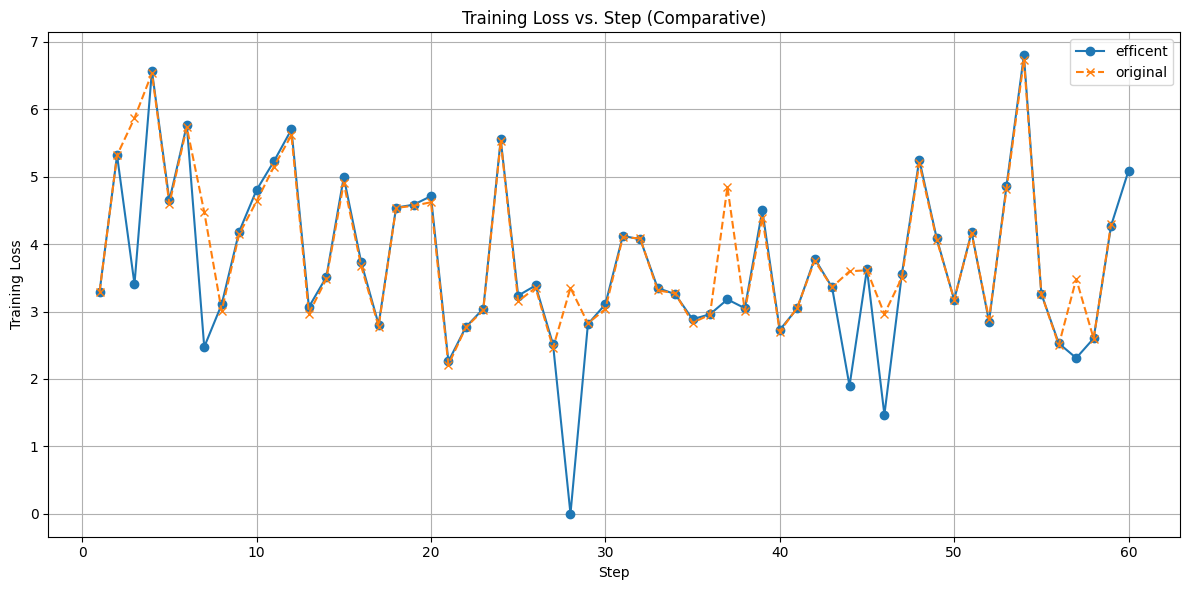

In [3]:
del model
import gc
gc.collect()
torch.cuda.empty_cache()

GRPO_memory_efficient_linear_works below:

In [4]:
def transformation_function_grpo(new_hidden_states, old_hidden_states,linear, input_ids, completion_mask, advantages, epsilon,beta):

    nlogits = linear(new_hidden_states).float()
    ologits = linear(old_hidden_states).float()

    selected_logits_n = torch.gather(nlogits, dim=-1, index=input_ids.unsqueeze(-1)).squeeze(-1)
    selected_logits_o = torch.gather(ologits, dim=-1, index=input_ids.unsqueeze(-1)).squeeze(-1)

    per_token_logps_n = selected_logits_n - torch.logsumexp(selected_logits_n, dim=-1)
    per_token_logps_o = selected_logits_o - torch.logsumexp(selected_logits_o, dim=-1)
    # this needs a ref_model (we should replace this with ref model for real impl)
    per_token_kl = torch.exp(per_token_logps_o - per_token_logps_n) - (per_token_logps_o - per_token_logps_n) - 1
    coef_1 = torch.exp(per_token_logps_n - per_token_logps_o.detach())
    #print("cof", coef_1)
    coef_2 = torch.clamp(coef_1, 1 - epsilon, 1 + epsilon)
    per_token_loss1 = coef_1 * advantages.unsqueeze(1)
    per_token_loss2 = coef_2 * advantages.unsqueeze(1)
    per_token_loss = -torch.min(per_token_loss1, per_token_loss2)
    if beta != 0.0:
        per_token_loss = per_token_loss1 + beta * per_token_kl
    loss = (per_token_loss1 * completion_mask).sum() / completion_mask.sum()
    #print(loss)
    return loss


import torch

class GRPO_memory_efficient_linear(torch.autograd.Function):
    @staticmethod
    def forward(ctx, new_hidden_states, old_hidden_states, linear, input_ids, mask, advantages, beta = 0,epsilon = 0.2, n_chunks=1):
        device = new_hidden_states.device

        # Get original dimensions.
        B, T, H = new_hidden_states.shape
        # print(new_hidden_states.shape)
        # print(old_hidden_states.shape)
        # print(input_ids.shape)
        # print(mask.shape)
        # print(advantages.shape)
        # Exclude the last time step from new/old hidden states and associated tensors.
        new_hs_flat = new_hidden_states[:, :-1, :].reshape(-1, H)       # shape: [B*(T-1), H]
        old_hs_flat = old_hidden_states[:, :-1, :].reshape(-1, H)         # shape: [B*(T-1), H]
        ids_flat    = input_ids.reshape(-1)                       # shape: [B*(T)]
        mask_flat   = mask.reshape(-1)                             # shape: [B*(T)]
        adv_flat    = advantages                                          # shape: [B]

        # Allocate a gradient tensor for the flattened new_hidden_states.
        grad_flat = torch.empty_like(new_hs_flat)
        accumulated_loss = torch.zeros(1, device=device)

        # Chunk the flattened tensors along the first (combined) dimension.
        grad_chunks  = torch.chunk(grad_flat, n_chunks, dim=0)
        new_chunks   = torch.chunk(new_hs_flat, n_chunks, dim=0)
        old_chunks   = torch.chunk(old_hs_flat, n_chunks, dim=0)
        ids_chunks   = torch.chunk(ids_flat, n_chunks, dim=0)
        mask_chunks  = torch.chunk(mask_flat, n_chunks, dim=0)
        adv_chunks   = torch.chunk(adv_flat, n_chunks, dim=0)

        # Process each chunk using torch.func.grad_and_value.
        for grad_chunk, new_chunk, old_chunk, ids_chunk, mask_chunk, adv_chunk in zip(
                grad_chunks, new_chunks, old_chunks, ids_chunks, mask_chunks, adv_chunks):
            # Ensure new_chunk is detached and requires gradient.
            new_chunk = new_chunk.detach().requires_grad_()

            # Compute gradients and loss in one shot.
            (chunk_grad, chunk_loss) = torch.func.grad_and_value(
                transformation_function_grpo,
                argnums=0,
                has_aux=False,
            )(new_chunk, old_chunk, linear, ids_chunk, mask_chunk, adv_chunk, epsilon,beta)

            grad_chunk.copy_(chunk_grad)
            accumulated_loss += chunk_loss  # accumulate the unscaled loss

        # Average gradients and loss over all chunks.
        grad_flat.div_(n_chunks)
        accumulated_loss.div_(n_chunks)

        # Reassemble the gradient for new_hidden_states:
        # Create a zero tensor for full new_hidden_states gradient.
        grad_new_hidden = torch.zeros_like(new_hidden_states)
        # Insert the computed gradient for tokens [:-1].
        grad_new_hidden[:, :-1, :] = grad_flat.view(B, T -1 , H)

        # Save the gradient for backward.
        ctx.save_for_backward(grad_new_hidden)
        return accumulated_loss

    @staticmethod
    def backward(ctx, grad_output, dcompletion_length=None, dmean_kl=None):
        (grad_input,) = ctx.saved_tensors
        return grad_input, None, None, None, None, None, None, None, None



In [5]:
from transformers.modeling_outputs import (
    CausalLMOutputWithPast,
)

from typing import Callable, List, Optional, Tuple, Union

def forward_grpo(
    self,
    input_ids: torch.LongTensor = None,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_values = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    cache_position: Optional[torch.LongTensor] = None,
    logits_to_keep: Union[int, torch.Tensor] = 0,
    **kwargs,
) -> Union[Tuple, CausalLMOutputWithPast]:

    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = (
        output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    )
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
    outputs = self.model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        position_ids=position_ids,
        past_key_values=past_key_values,
        inputs_embeds=inputs_embeds,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
        cache_position=cache_position,
        **kwargs,
    )

    hidden_states = outputs[0]
    # Only compute necessary logits, and do not upcast them to float if we are not computing the loss
    slice_indices = slice(-logits_to_keep, None) if isinstance(logits_to_keep, int) else logits_to_keep

    if hidden_states.shape[0] * hidden_states.shape[1] <= 512:
        logits = self.lm_head(hidden_states[:, slice_indices, :])
    else:
        logits = hidden_states[:, slice_indices, :]

    loss = None

    return CausalLMOutputWithPast(
        loss=loss,
        logits=logits,
        past_key_values=outputs.past_key_values,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )
import transformers.models.llama.modeling_llama
transformers.models.llama.modeling_llama.LlamaForCausalLM.forward = forward_grpo


def _get_per_token_logps(self, model, input_ids, attention_mask, logits_to_keep):
    # We add 1 to `logits_to_keep` because the last logits of the sequence is later excluded
    #logits = model(input_ids=input_ids, attention_mask=attention_mask, logits_to_keep=logits_to_keep + 1).logits
    #logits = hidden_states[:, :-1, :]  # (B, L-1, V), exclude the last logit: it corresponds to the next token pred

    #input_ids = input_ids[:, -logits_to_keep:]
    # For transformers<=4.48, logits_to_keep argument isn't supported, so here we drop logits ourselves.
    # See https://github.com/huggingface/trl/issues/2770
    #logits = logits[:, -logits_to_keep:]
    return None

from trl import GRPOConfig, GRPOTrainer
GRPOTrainer._get_per_token_logps = _get_per_token_logps

def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    if return_outputs:
        raise ValueError("The GRPOTrainer does not support returning outputs")
    # Compute the per-token log probabilities for the model

    prompt_ids, prompt_mask = inputs["prompt_ids"], inputs["prompt_mask"]
    completion_ids, completion_mask = inputs["completion_ids"], inputs["completion_mask"]
    input_ids = torch.cat([prompt_ids, completion_ids], dim=1)
    attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)
    logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens

    #per_token_logps = self._get_per_token_logps(model, input_ids, attention_mask, logits_to_keep)

    # Compute the KL divergence between the model and the reference model
    # if self.beta != 0.0:
    #     ref_per_token_logps = inputs["ref_per_token_logps"]
    #     per_token_kl = (
    #         torch.exp(ref_per_token_logps - per_token_logps) - (ref_per_token_logps - per_token_logps) - 1
    #     )

    # Compute the loss
    advantages = inputs["advantages"]
    # When using num_iterations == 1, old_per_token_logps == per_token_logps, so we can skip it's computation (see
    # _generate_and_score_completions) and use per_token_logps.detach() instead.
    # old_per_token_logps = inputs["old_per_token_logps"] if self.num_iterations > 1 else per_token_logps.detach()
    # coef_1 = torch.exp(per_token_logps - old_per_token_logps)
    # coef_2 = torch.clamp(coef_1, 1 - self.epsilon, 1 + self.epsilon)
    # per_token_loss1 = coef_1 * advantages.unsqueeze(1)
    # per_token_loss2 = coef_2 * advantages.unsqueeze(1)
    # per_token_loss = -torch.min(per_token_loss1, per_token_loss2)
    # if self.beta != 0.0:
    #     per_token_loss = per_token_loss + self.beta * per_token_kl
    # loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()
    new_hidden_states = model(input_ids = input_ids, logits_to_keep = logits_to_keep + 1).logits
    with torch.no_grad():
        old_hidden_states = model(input_ids = input_ids, logits_to_keep = logits_to_keep + 1).logits

    n_chunks = 2

    loss = GRPO_memory_efficient_linear.apply(
        new_hidden_states, old_hidden_states, model.lm_head,
        completion_ids, completion_mask, advantages, self.beta,
        0.2,
        n_chunks,
    )
    # No metrics for this simple impl
    # Log the metrics
    # mode = "eval" if self.control.should_evaluate else "train"

    # if self.beta != 0.0:
    #     mean_kl = (per_token_kl * completion_mask).sum() / completion_mask.sum()
    #     self._metrics[mode]["kl"].append(self.accelerator.gather_for_metrics(mean_kl).mean().item())

    # is_clipped = (per_token_loss1 < per_token_loss2).float()
    # clip_ratio = (is_clipped * completion_mask).sum() / completion_mask.sum()
    # self._metrics[mode]["clip_ratio"].append(self.accelerator.gather_for_metrics(clip_ratio).mean().item())
    return loss

GRPOTrainer.compute_loss = compute_loss

In [6]:
import re
from datasets import load_dataset, Dataset

# Load and prep dataset
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

# uncomment middle messages for 1-shot prompting
def get_gsm8k_questions(split = "train") -> Dataset:
    data = load_dataset('openai/gsm8k', 'main')[split] # type: ignore
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

dataset = get_gsm8k_questions()

# Reward functions
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, Trainer
from peft import get_peft_model, LoraConfig, TaskType
import os

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = \
    "expandable_segments:True,"\
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"

max_seq_length = 1024
#torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct"
dtype = torch.float16
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit              = True,
#     bnb_4bit_use_double_quant = True,
#     bnb_4bit_quant_type       = "nf4",
#     bnb_4bit_compute_dtype    = dtype,
# )
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    #quantization_config = bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

lora_config = LoraConfig(
    r = 32,
    lora_alpha = 64,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0,
    bias = "none",
    task_type = TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name : param.requires_grad_(True)
        else: param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.lm_head.weight.requires_grad = True
model.enable_input_require_grads()


training_args = GRPOConfig(
    use_vllm = False,
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    fp16 = model.get_input_embeddings().weight.dtype == torch.float16,
    bf16 = model.get_input_embeddings().weight.dtype == torch.bfloat16,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 1,
    num_generations = 4,
    max_prompt_length = 256,
    max_completion_length = 200,
    max_steps = 40,
    save_steps = 20,
    max_grad_norm = 0.1,
    report_to = "none",
    output_dir = "outputs",
)

trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()

-------------------- Question:
Ahmed and Emily are having a contest to see who can get the best grade in the class. There have been 9 assignments and Ahmed has a 91 in the class. Emily has a 92. The final assignment is worth the same amount as all the other assignments. Emily got a 90 on the final assignment. What is the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers? 
Answer:
100 
Response:
resolving for minimum grade Ahmed needs to get, we need to set up an equation based on given information.

The total number of assignments is 9, 
the total percentage points for Ahmed and Emily's classes are 9 * 100 = 900 percent.
The total percentage points for the three assignments is 9 * 100 = 900 percent.
Emily's grade of 92 is 92/100 = 0.92 and the grade she got on the final assignment is 90/100 = 0.9. 

A minimum grade Ahmed needs to get to beat Emily can be calculated using the following equation:
91x + (x + 1) = 0.92 + 0.9 + 0.9x

90x + x + 1 = 2.81 + 0.9x
91

Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


-------------------- Question:
The gauge on a water tank shows that the tank is 1/3 full of water. To fill the tank, 16 gallons of water are added. How many gallons of water does the tank hold when full? 
Answer:
24 
Response:
To find the total capacity of the tank, we need to use the information given. We are told that 1/3 of the tank is full, and 16 gallons are added to fill the tank. 

First, let's determine the fraction of the tank that 16 gallons represents. Since 1/3 is the fraction of the tank that is full, 16 gallons represents 16/(1/3) = 16 * 3 = 48/3 = 16 * 16/3 = 256/3 of the tank capacity.

Now, we know that 256/3 of the tank is full. Therefore, to find the full tank capacity, we can divide 256/3 by 1/3. 

(256/3) / (1/3) = 256/3 * 3 = 256 * 1 = 256 gallons. 

Therefore, the tank holds 256 gallons when full. 
Extracted:
To find the total capacity of the tank, we need to use the information given. We are told that 1/3 of the tank is full, and 16 gallons are added to fill the

TrainOutput(global_step=40, training_loss=0.0, metrics={'train_runtime': 444.7556, 'train_samples_per_second': 0.36, 'train_steps_per_second': 0.09, 'total_flos': 0.0, 'train_loss': 0.0})

To test your implementation, it should not OOM for large inputs. Also, check the gradient is actually equivalent via `torch.allclose` in the normal approach.

## Marking Criteria for E) Max points = 10
```python
if attemped_E:
    E_score = 0
    if VRAM_50_percent_reduction: E_score += 2
    if remove_float32_upcast: E_score = 0
    if show_ce_loss_works: E_score += 1
    if show_other_functions_work: E_score += 1
    if hardcoded_gradients: E_score = 0
    if allows_dynamic_chunk_sizes: E_score += 1
    if llama_1B_training_loss_matches: E_score += 1
    else: E_score = 0
    if GRPO_memory_efficient_linear_works: E_score += 4
    final_score += E_score
else:
    final_score += 0
```

---
---
---
<a name="SUBMISSION"></a>
## Submission Steps

1. All code should be in a public Github (Apache 2 Licensed)
2. Kaggle notebooks and Colab notebooks should be linked in the README, and can be accessible through Colab / Kaggle.
3. If attaching notebooks, must attach fully run ones - do not just add a notebook without running it. Kaggle notebook must be public, and run.
4. Submit the Github to https://forms.gle/crSYnsGq3t1ck5TB9 If you want to send a private repo, please add me as a Github collaborate @danielhanchen
5. Provide screenshots, graphs, plots, etc especially for training loss curves.
6. We will comment and respond inside your Github repo. There will get 1 interview as well as a final step!

### Clarifications:
1. We'll compensate you if we interview you but don't hire you
2. \$100-\$1000 bounties for Task 4
3. Submissions must be Apache-2 licensed
4. Task 4 involves solving Github issues for OSS Unsloth
5. No time limit: rolling basis
6. US based preferred